# MLA'19 Twitter analysis and wordcloud generation
Below is the code I have been using to generate the graphs and wordclouds associated with the 2019 Medical Library Association annual conference in Chicago.

I have been hacking this together over a number of conferences, and over a period of time. By request, I am sharing it here for the enlightenment and curiosity of others. I have attempted to clean it up a little bit, and add some cursory comments to help people understand which parts are doing what. However, this is not intended to be a tutorial, nor do I claim a deep understanding of every element of what I utilize here. I am only beginning my journey with Natural Language Processing. 

So to anyone who ventures below: Thanks for having a look! I always welcome advice and suggestions from peers and veterans, so feel free to contribute, or shoot me an email. 

Cheers and regards!

Peter

```
Peter Oxley, PhD
Associate Director of Research Services

Weill Cornell Medicine
Information Technologies and Services
Samuel J. Wood Library & C.V. Starr Biomedical Information Center
1300 York Avenue Room D-120
New York, NY 10065-4896
(P) 646-962-2576
 
pro2004@med.cornell.edu
```

## Getting started
This was originally run in a Jupyterlab notebook. For those interested in giving it a go:

1. Download this notebook from https://github.com/oxpeter/mlanet18_twitter/archive/master.zip

2. Unzip the folder that downloads

1. Download Anaconda from https://www.anaconda.com/download/ (select your operating system, then click 'Download'

2. Run the Anaconda installer you just downloaded. When it asks which version of Python to install, select 3.6 (or higher)

3. Open Anaconda

4. Open Jupyterlab (click 'Launch')

5. In Jupyterlab, on the left-hand "Files" panel, navigate to where you downloaded this notebook folder

6. The notebook should now load!

7. You will need to install a number of extra modules for this notebook to run. You can do so in Anaconda by: 
    1. clicking on the Environments panel on the left
    2. selecting "all" instead of "installed" modules
    3. searching for the modules in the right panel 
    4. selecting the check box next to each module name
    5. clicking "apply" in the bottom right
    6. it will tell you all the modules (and their dependencies) it wants to install. Click 'OK'
    
8. An alternative means of installing is to use the terminal, with the command:
    ```conda install module1 module2 module3```
    
You will need to install the following modules (Anaconda will already have installed some of these by default):

* pandas
* numpy
* matplotlib
* seaborn
* pillow
* nltk
* wordcloud

### Using Python in Jupyterlab
This Jupyter notebook has been built to run on a python 3 'kernel'. That means you can enter python code into the code cells, and it will be able to execute as python.

To execute code, select the cell(s) by clicking inside, then either:

* Choose "Run Selected Cells" from the Command tab on the left
* Click the run button (triangle) at the top of the notebook
* Press "Shift + Enter"


## Import the needed modules

In [1]:
# import basic modules
from collections import Counter
import os
from os import path
import re

In [2]:
# import graphing modules (and configure to display in the notebook)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image  # for creating wordcloud image masks

In [3]:
# import modules for working with tabular data
import numpy as np
import pandas as pd

In [4]:
# import nltk for importing Twitter data, and performing NLP
from nltk.twitter import Query, Streamer, Twitter, TweetViewer, TweetWriter, credsfromfile
from nltk.tokenize import TweetTokenizer
from nltk.twitter.common import json2csv_entities

## Query Twitter for hashtag



Tweets are pulled using [NTLK's Twitter module](http://www.nltk.org/howto/twitter.html). The key steps are as follows:


```oauth = credsfromfile()``` gets the stored API key information from the `credentials.txt` file in the directory specified by the TWITTER environment variable. You can create your API key using the instructions from http://www.nltk.org/howto/twitter.html. 

This authentication info is passed to `Query()`, which calls twitter's [Search API](https://dev.twitter.com/rest/public). This lets us query past tweets. Although Twitter delivers tweets as [JSON](http://www.json.org) objects, the Python client encodes them as dictionaries.



#### Set the environment variable that points to the Twitter credentials file

In [5]:
twitter_credentials = path.join(os.getcwd(),'twitter-files')

In [6]:
%env TWITTER {twitter_credentials}

env: TWITTER=/Users/poxley/Documents/05. Conferences/2019-05 MLA Chicago/twitter-files


### Get tweets!

In [534]:
oauth = credsfromfile()
client = Query(**oauth)
tweets = client.search_tweets(keywords='#mlanet19 OR #mlanet2019', limit=10000)

Twitter's own documentation [provides a useful overview of all the fields in the JSON object](https://dev.twitter.com/overview/api/tweets) and it may be helpful to look at this [visual map of a Tweet object](http://www.scribd.com/doc/30146338/map-of-a-tweet).

Since each Tweet is converted into a Python dictionary, it's straightforward to just show a selected field, such as the value of the `'text'` key.

In [488]:
# saving tweets to json file
import json

In [535]:
json_tweets = "tweets_mlanet19.json"

In [536]:
handle = open(json_tweets, 'w')
for i,t in enumerate(tweets):
    handle.write(json.dumps(t) + '\n')
    # print(t['text'])
handle.close()
print(i, "tweets written to {}".format(json_tweets))

No more Tweets available through rest api
7681 tweets written to tweets_mlanet19.json


### Convert .json to .csv and extract twitter metadata

If we want to carry out analyses on the tweets, we have to work directly with the file rather than via the corpus reader.

The function `json2csv()` takes as input a file-like object consisting of Tweets as line-delimited JSON objects and returns a file in CSV format. The third parameter of the function lists the fields that we want to extract from the JSON. All the fields available are described in [the official Twitter API](https://dev.twitter.com/overview/api/tweets).

In [11]:
from nltk.twitter.common import json2csv

The following will generate a CSV file including most of the metadata together with the id of the user who has published it.

In [537]:
tweet_metadata_file = 'tweets_mlanet19_metadata.csv'
with open(json_tweets) as fp:
    json2csv(fp, tweet_metadata_file,
            ['created_at', 'favorite_count', 'id', 'in_reply_to_status_id', 
            'in_reply_to_user_id', 'retweet_count', 'retweeted', 
            'text', 'truncated', 'user.id', 'user.screen_name'])

The first nine elements of the list are attributes of the Tweet, while the last two, `user.id` and `user.screen_name`, take the user object associated with the Tweet, and retrieve the attributes in the list (in this case the id and twitter handle). The object for the Twitter user is described in the  [Twitter API for users](https://dev.twitter.com/overview/api/users).

Additionally, when a Tweet is actually a retweet, the original tweet can be also fetched from the same file, as follows:

In [538]:
with open(json_tweets) as fp:
    json2csv_entities(fp, 'tweets_mlanet19.original_tweets.csv',
                        ['id'], 'retweeted_status', ['created_at', 'favorite_count', 
                        'id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweet_count',
                        'text', 'truncated', 'user.id'])

Here the first id corresponds to the retweeted Tweet, and the second id to the original Tweet.

### Read CSV data into a [Pandas](http://pandas.pydata.org/) Dataframe

In [539]:
tweets = pd.read_csv(tweet_metadata_file, index_col=2, header=0, encoding="utf8")

# adjust to local time (time reported is UTC)
tweets.created_at = pd.to_datetime(tweets.created_at) - pd.DateOffset(hours=5) 
tweets.head(3)

,created_at,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,retweeted,text,truncated,user.id,user.screen_name
id,,,,,,,,,,
1126217080867622912,2019-05-08 15:07:30+00:00,0,NaN,NaN,0,False,Thanks @hurstej and @pfanderson for the excess...,True,20427463,wichor
1126216562413899783,2019-05-08 15:05:27+00:00,2,NaN,NaN,0,False,At o hare to catch my 17:55 flight back to ams...,True,20427463,wichor
1126214069579595776,2019-05-08 14:55:32+00:00,0,NaN,NaN,3,False,"RT @evardell: ""Who's on the (health care) team...",False,611367496,Basia_Delawska


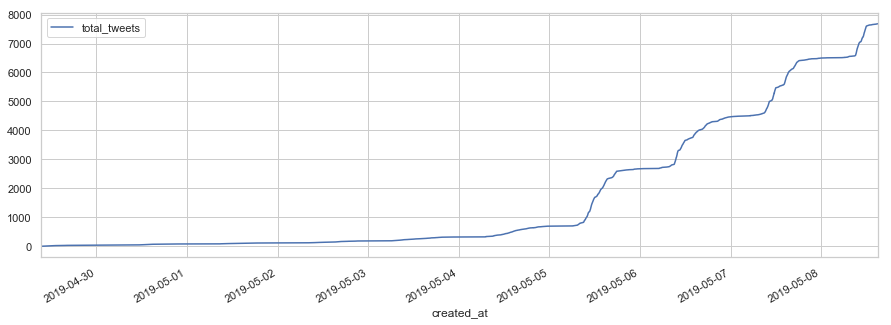

In [540]:
tweet_time = tweets[['created_at', 'user.screen_name']].copy()
tweet_time['total_tweets'] = pd.DataFrame(np.arange(len(tweets)+1,1,-1), index=tweets.index)
fig, ax = plt.subplots(figsize=(15,5))
tweet_time.plot(y='total_tweets', x='created_at', ax=ax)

Tokenize the tweets and append the list to the dataframe

In [541]:
tknzr = TweetTokenizer(preserve_case=False)

In [542]:
tweets["tknzd"] = tweets.text.apply(tknzr.tokenize)

## Filter tweets
### filter tweets by time sent

In [543]:
# filter for only tweets that occur within a specific time period
after_hours = tweets[(tweets.created_at.dt.hour >= 18) |
                      (tweets.created_at.dt.hour < 7)
                    ]
daytime_hours = tweets[(tweets.created_at.dt.hour >= 7) |
                       (tweets.created_at.dt.hour < 18)
                      ]
pre_conference = tweets[(tweets.created_at <= "05-04-2019 17:00:00")]

sunday_daytime = tweets[(tweets.created_at >= "05-05-2019 07:00:00") & 
                        (tweets.created_at < "05-05-2019 19:00:00")
                       ]
sunday_nighttime = tweets[(tweets.created_at >= "2019-05-05 19:00:00") &
                          (tweets.created_at < "2019-05-06 07:00:00")
                       ]
monday_daytime = tweets[(tweets.created_at >= "2019-05-06 07:00:00") & 
                        (tweets.created_at < "2019-05-06 19:00:00")
                       ]
monday_nighttime = tweets[(tweets.created_at >= "2019-05-05 19:00:00") &
                          (tweets.created_at < "2019-05-06 07:00:00")
                       ]
janet_doe = tweets[(tweets.created_at >= "2019-05-06 09:00:00") &
                          (tweets.created_at < "2019-05-06 10:00:00")
                       ]
business_meeting = tweets[(tweets.created_at >= "2019-05-07 09:00:00") &
                          (tweets.created_at < "2019-05-07 10:00:00")
                       ]
nlm_updates = tweets[(tweets.created_at >= "2019-05-07 11:00:00") &
                          (tweets.created_at < "2019-05-07 12:00:00")
                       ]

period_plenary = tweets[(tweets.created_at >= "2019-05-08 09:00:00") &
                          (tweets.created_at < "2019-05-08 10:15:00")
                       ]

improv_plenary = tweets[(tweets.created_at >= "2019-05-08 10:30:00") &
                          (tweets.created_at < "2019-05-08 12:00:00")
                       ]
# other periods to capture:
# business meeting
# plenary sessions
# talent show
# ??


### get word lists and filter tweets by content

In [544]:
retweet_mask = tweets.text.str.contains("^RT")

allwords = [w for wlists in tweets.tknzd.values for w in wlists]

# remove any retweets (to get the distribution of original content)
no_RT_words = [w  for wlists in tweets[~retweet_mask].tknzd.values for w in wlists ]

# get the word lists for the preconference tweets
preconference_noRT = [w  for wlists in pre_conference[~pre_conference.text.str.contains("^RT")].tknzd.values for w in wlists ]
preconference_wRT = [w  for wlists in pre_conference.tknzd.values for w in wlists ]


# get the word lists for day and night
after_hours_noRT = [w  for wlists in after_hours[~after_hours.text.str.contains("^RT")].tknzd.values for w in wlists ]
day_hours_noRT = [w  for wlists in daytime_hours[~daytime_hours.text.str.contains("^RT")].tknzd.values for w in wlists ]
 
after_hours_wRT = [w  for wlists in after_hours.tknzd.values for w in wlists ]
day_hours_wRT = [w  for wlists in daytime_hours.tknzd.values for w in wlists ]

# get words from other specific events
monday_day_wRT = [w  for wlists in monday_daytime.tknzd.values for w in wlists ]
monday_night_wRT = [w  for wlists in monday_nighttime.tknzd.values for w in wlists ]

janet_doe_wRT = [w  for wlists in janet_doe.tknzd.values for w in wlists ]

business_meeting_wRT = [w  for wlists in business_meeting.tknzd.values for w in wlists ]

nlm_update_wRT = [w  for wlists in business_meeting.tknzd.values for w in wlists ]

period_wRT = [w  for wlists in period_plenary.tknzd.values for w in wlists ]

improv_wRT = [w  for wlists in improv_plenary.tknzd.values for w in wlists ]
# keeping 2018's for modification:


## Analyse tweets
First, we will summarize the tweet data for all Twitter users. We want to look at the type of content of their tweets, according to whether they are original tweets, replies to another tweet, or a retweet, as well as the timing of users' tweets. 

First, we create some new columns to indicate the type of tweet, or the hour of the day it was made:

In [545]:
tweets['is_retweet'] = tweets.tknzd.apply(lambda x: True if x[0]=="rt" else False)
tweets['is_reply'] = tweets.in_reply_to_user_id.apply(lambda x: False if pd.isna(x) else True)
tweets["creation_hour"] = tweets.created_at.dt.hour

Now we create the summary table:

In [546]:
tweet_analysis = tweets.groupby("user.screen_name").agg({'retweet_count':np.mean,
                                                        'favorite_count':np.mean,
                                                        'creation_hour':np.mean,
                                                        'created_at':np.count_nonzero,
                                                        'is_retweet':np.sum,
                                                        'is_reply':np.sum,
                                                       })
tweet_analysis['created_at'] = tweet_analysis[['created_at']].astype(int)
tweet_analysis['is_retweet'] = tweet_analysis[['is_retweet']].astype(int)
tweet_analysis['is_reply'] = tweet_analysis[['is_reply']].astype(int)

tweet_analysis = tweet_analysis.rename(columns={"retweet_count":"retweet_mean",
                                                "favorite_count":"favorite_mean",
                                                "created_at":"total_tweets",
                                               })

/Users/poxley/anaconda3/envs/scikit/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:844: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  f = lambda x: func(x, *args, **kwargs)


In [547]:
tweet_analysis.sort_values("total_tweets", ascending=False).head()

,retweet_mean,favorite_mean,creation_hour,total_tweets,is_retweet,is_reply
user.screen_name,,,,,,
hurstej,0.836735,2.133787,12.184807,882,127,1
pfanderson,1.363985,1.616858,11.598978,783,316,133
akaur0,1.738977,0.925926,11.638448,567,416,75
wichor,0.343164,1.868633,12.410188,373,4,171
VPannabecker,2.621212,0.245455,14.172727,330,304,21


In [548]:
tweet_analysis['is_original'] = (tweet_analysis.total_tweets - tweet_analysis.is_reply - tweet_analysis.is_retweet)

In [549]:
tweet_analysis.loc["oxpeter",:]

retweet_mean      1.756757
favorite_mean     3.378378
creation_hour    12.540541
total_tweets     37.000000
is_retweet        7.000000
is_reply         14.000000
is_original      16.000000
Name: oxpeter, dtype: float64

In [550]:
tweet_analysis[tweet_analysis.index.str.contains('jolene', case=False)]

,retweet_mean,favorite_mean,creation_hour,total_tweets,is_retweet,is_reply,is_original
user.screen_name,,,,,,,
JoleneMiller419,0.876712,3.479452,11.945205,73,13,9,51


In [551]:
def get_prolifics(tweet_analysis, top=10):
    """
    This function pulls out the top n users by total tweets, original content, replies, 
    and retweets. It returns all these sub-tables, as well as a concatenation of all of
    the above, which encompasses all users who were included in at least one of the 
    above lists.
    """
    
    # set the top n list:
    most_prolific = tweet_analysis.sort_values('total_tweets',ascending=False).head(top)
    most_engaging = tweet_analysis.sort_values('is_reply',ascending=False).head(top)
    most_distributive = tweet_analysis.sort_values('is_retweet',ascending=False).head(top)
    most_original = tweet_analysis.sort_values('is_original' ,ascending=False).head(top)

    # tweet_analysis[tweet_analysis.index.isin()]
    top_performers_list = pd.concat([most_prolific, most_engaging, most_distributive, most_original], axis=0).index.unique()
    df_topperf = tweet_analysis[tweet_analysis.index.isin(top_performers_list)].sort_values('total_tweets',ascending=False)
    return most_prolific, most_engaging, most_distributive, most_original, df_topperf

### Create facet plot
Created a faceted plot of all the top 10 groups:

In [552]:
(most_prolific, 
 most_engaging, 
 most_distributive, 
 most_original, 
 df_topperf) = get_prolifics(tweet_analysis, 10)

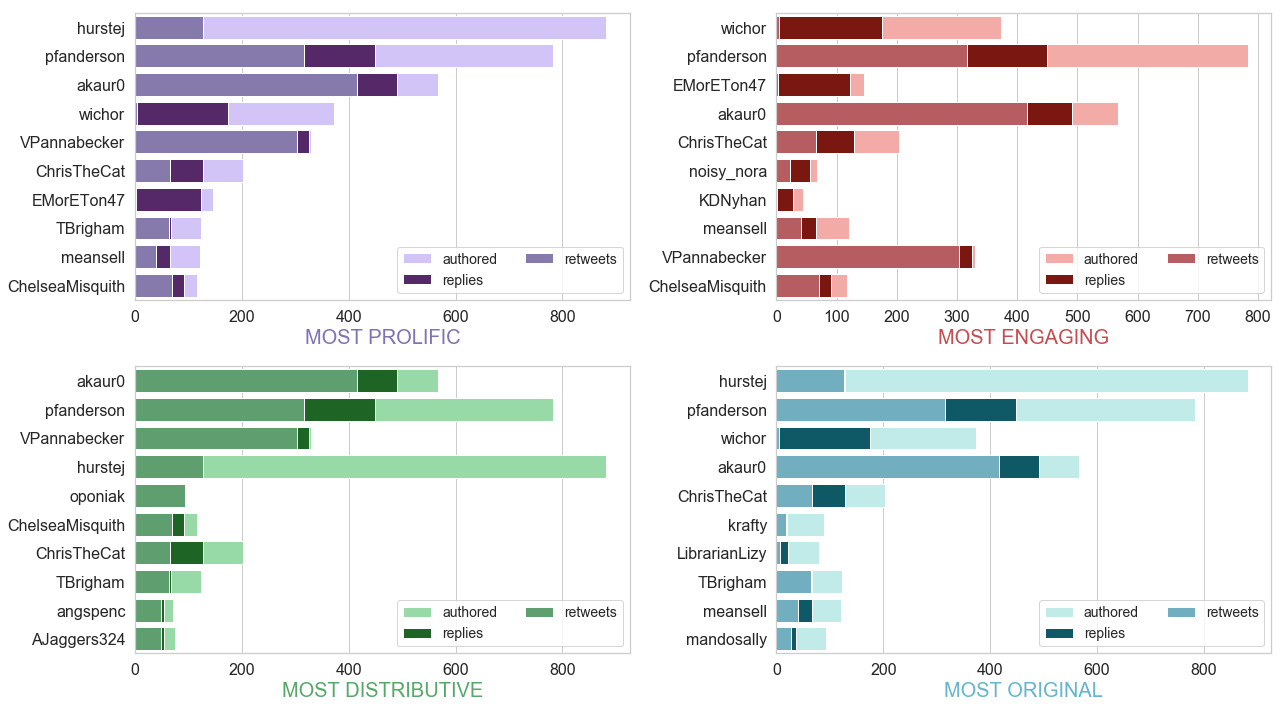

In [553]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

for ax,df,xlab,c in zip([ax1,ax2,ax3,ax4], 
                      [most_prolific, most_engaging, most_distributive, most_original],
                      ["PROLIFIC", "ENGAGING", "DISTRIBUTIVE", "ORIGINAL"],
                      ['m', 'r', 'g', 'c']
                     ):
    plt.sca(ax)
    sns.set_color_codes("pastel")
    sns.barplot(y=df.index, x=df['total_tweets'], ax=ax, color=c, label="authored")
    sns.set_color_codes("dark")
    sns.barplot(y=df.index, x=df['is_retweet']+df['is_reply'], ax=ax, color=c, label="replies")
    sns.set_color_codes("deep")
    sns.barplot(y=df.index, x=df['is_retweet'], ax=ax, color=c, label="retweets")

    # customize plot settings
    ax.legend(ncol=2, loc="lower right", frameon=True, fontsize=14)
    plt.xlabel("MOST {}".format(xlab), fontsize=20, color=c)
    plt.ylabel("")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

# save and display
plt.tight_layout()
plt.savefig("twitter_graphs/graph_most_prolific_facet_may8_FINAL.png")
plt.show()

### Create a single aggregate plot of the above
Because most users are common to all plots, we can pool these four graphs into one. 

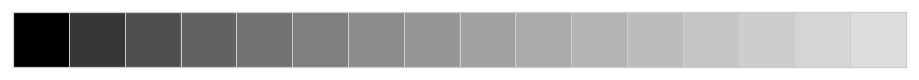

In [554]:
# to overlap these graphs together, we need a greyscale for elements that are not part of the top n users
sns.palplot(sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=0, dark=0, light=.75, reverse=True))
cmap = sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=0, dark=0, light=.75, reverse=True, as_cmap=True)

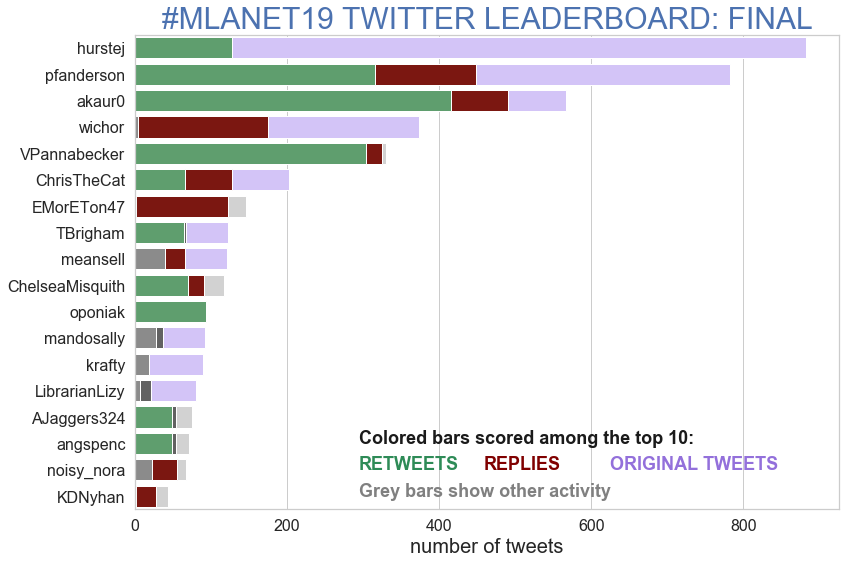

In [555]:
sns.set(style="whitegrid")
cmap = sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=0, 
                             dark=0, light=.75, reverse=True, as_cmap=True)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

sns.set_color_codes("pastel")
sns.barplot(y=df_topperf.index, 
            x=df_topperf['total_tweets'], 
            palette=list(map(lambda x: 'm' if x else cmap(0.9), 
                             df_topperf.index.isin(most_original.index))),
            ax=ax, label="authored", 
           )

sns.set_color_codes("dark")
sns.barplot(y=df_topperf.index, 
            x=df_topperf['is_retweet']+df_topperf['is_reply'], 
            palette=list(map(lambda x: 'r' if x else cmap(0.2), 
                             df_topperf.index.isin(most_engaging.index))), 
            label="replies", ax=ax, 
           )

sns.set_color_codes("deep")
sns.barplot(y=df_topperf.index, 
            x=df_topperf['is_retweet'], 
            palette=list(map(lambda x: 'g' if x else cmap(0.4), 
                             df_topperf.index.isin(most_distributive.index))), 
            ax=ax, label="retweets"
           )

# customize plot settings
# determine scale of plot
xmax = df_topperf.total_tweets.max()
leg_start = int(xmax/3)
leg_int = int(xmax/8)
leg_replies = leg_start + 1.5*leg_int
leg_original = leg_replies + 1.5*leg_int

# Create a legend:
plt.annotate("Colored bars scored among the top 10:", (leg_start, len(df_topperf.index) - 3), 
             color='k', fontweight='bold', fontsize=18)
plt.annotate("Grey bars show other activity", (leg_start, len(df_topperf.index) - 1), 
             color='grey', fontweight='bold', fontsize=18)


plt.annotate("RETWEETS", (leg_start, len(df_topperf.index) - 2), 
             color='seagreen', fontweight='bold', fontsize=18)
plt.annotate("REPLIES", (leg_replies, len(df_topperf.index) - 2), 
             color='maroon', fontweight='bold', fontsize=18)
plt.annotate("ORIGINAL TWEETS", (leg_original, len(df_topperf.index) - 2), 
             color='mediumpurple', fontweight='bold', fontsize=18)

plt.title("#MLANET19 TWITTER LEADERBOARD: FINAL", fontsize=30, color='b')
plt.ylabel("")
plt.xlabel("number of tweets", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# save and display
plt.tight_layout()
plt.savefig("twitter_graphs/graph_most_prolific_may8_FINAL.png")
plt.show()


### Create Bokeh plot
This is just my first foray into Bokeh plots, and is pretty crude.

In [448]:
import bokeh.plotting as bplt #import figure, output_file, show
from bokeh.models import ColumnDataSource, CDSView, IndexFilter, HoverTool
from bokeh.layouts import gridplot
from math import pi

In [509]:
(most_prolific, 
 most_engaging, 
 most_distributive, 
 most_original, df_topperf) = get_prolifics(tweet_analysis, 30)

In [510]:
bokeh_data = df_topperf.reset_index(
                      ).rename(columns={"user.screen_name":"user", 
                                        "created_at":"total_tweets"
                                       })
bokeh_data['rt_rply'] = bokeh_data.is_reply + bokeh_data.is_retweet
bokeh_data.tail(3)

,user,retweet_mean,favorite_mean,creation_hour,total_tweets,is_retweet,is_reply,is_original,rt_rply
55,giustini,0.307692,2.461538,12.230769,13,0,12,1,12
56,tcshields,0.333333,1.750000,9.416667,12,0,11,1,11
57,CarolinaFan1982,1.000000,8.400000,10.400000,5,0,5,0,5


In [511]:
# output to static HTML file
bplt.output_notebook()
bplt.output_file("twitter_graphs/prolific_tweeters_bokeh_may8_endofconf.html")

# define data source
source = ColumnDataSource(data=bokeh_data)

# define hover output:
hover = HoverTool(tooltips=[("","@user",),
                            ("mean time of day", "@creation_hour"),
                            ("total tweets", "@total_tweets"),
                            ("original", "@is_original"),
                            ("replies", "@is_reply"),
                            ("retweets", "@is_retweet"),
                            ],
                  mode='vline',
                  names=['Retweets']
                 )

tools = ["pan","box_zoom","box_select", hover, "reset"]
p = bplt.figure(plot_height=600, 
                plot_width=1200, 
                x_range=bokeh_data.user.values,
                tools=tools,
               )

p.vbar(bottom='rt_rply',top='total_tweets', 
       x='index', width=0.8,
       hover_color="#249DF0", fill_color='#F35340', line_color='#F35340',
       source=source,
       legend="Original", name="Original",
      )
p.vbar(bottom='is_retweet', top='rt_rply', 
       x='index', width=0.8, 
       hover_color="#249DF0", fill_color='#FF9F0C', line_color='#FF9F0C',
       source=source,
       legend="Replies", name="Replies",
      )
p.vbar(bottom=0, top='is_retweet',
       x='index', width=0.8,
       hover_color="#249DF0", fill_color='#FFE22B', line_color='#FFE22B',
       source=source,
       legend="Retweets", name="Retweets",
      )

p.xaxis.major_label_orientation = pi/4

# show the results
bplt.show(p)

Loading BokehJS ...

### Look at tweets by time
both number of tweets by hour, and tweet content at different periods of the day

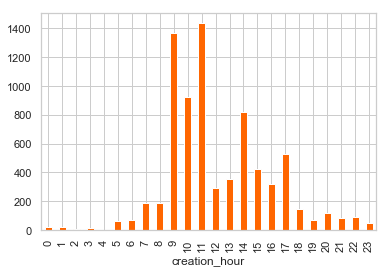

In [512]:
tweets.groupby("creation_hour").count()["user.id"].plot.bar(color="#ff6600")
plt.savefig("twitter_graphs/tweets_by_hour_may8_midway.png")

# Wordcloud

In [48]:
from wordcloud import WordCloud

### Create stopword set
customized to add the common twitter elements that we don't want cluttering our wordcloud

In [37]:
def get_stopwords(stop_tweeters=True, extras=[]):
    # start with a standard set of stopwords:
    stopwords = set(open("stopwords.txt", 'r').readline().split(','))

    if stop_tweeters:
        # remove all the twitter handles from the users
        twitter_handle_names = list(tweets["user.screen_name"].values)
    else:
        twitter_handle_names = []
        
    manual_stopwords = ["https","co","rt","don't","i'm","you're","i've", "it's",
              "nUaDgbMNgU","kuLfgZoEL0","kdfGPTtRow","PQQfWNyNGh","pe54vvn", "zSvLp3M55T",
              "7YNot1GvdT","stLeWaRLlF", "Shsapk86wb", "BX9Nz83yFh",
              "mlanet18", "mlanet19","medlib","medlibs",         
                       ]
    for w in twitter_handle_names + manual_stopwords + extras:
        stopwords.add(w)
    return stopwords

### Create colormaps
pull the desired cmap values from some of the existing cmaps on matplotlib, then smash them together into a new one (I don't have to worry about transitions between them, since the colors are being randomly selected from the full range anyway).

This code is based on the answer given in https://stackoverflow.com/questions/39024331/modifying-python-colormaps-to-single-value-beyond-a-specific-point

In [38]:
# get the darker colours from the "Reds" and "autumn" cmaps:
colors_reds1 = plt.cm.hot(np.linspace(0, 0.5, 128))
colors_reds2 = plt.cm.autumn(np.linspace(0, 0.5, 256))

# stacking the 2 arrays row-wise
colors = np.vstack((colors_reds1, colors_reds2))

# generating a smoothly-varying LinearSegmentedColormap
cmap_reds = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

In [39]:
colors_rainbow = plt.cm.rainbow(np.linspace(0, 1, 256))
colors_gistrain = plt.cm.gist_rainbow(np.linspace(0, 1, 256))
colors_jet = plt.cm.jet(np.linspace(0, 1, 256))

cmap_rainbow = mcolors.LinearSegmentedColormap.from_list('colormap', colors_rainbow)
cmap_gistrain = mcolors.LinearSegmentedColormap.from_list('colormap', colors_gistrain)
cmap_jet = mcolors.LinearSegmentedColormap.from_list('colormap', colors_jet)

In [40]:
# silver and gold colormap
# get the darker colours from the "Reds" and "autumn" cmaps:
colors1 = plt.cm.gist_gray(np.linspace(0.5, 1, 128))
colors2 = plt.cm.copper(np.linspace(0.66, 1, 128))
colors3 = plt.cm.Wistia(np.linspace(0, 1, 128))

# stacking the 2 arrays row-wise
colors = np.vstack((colors1, colors3, colors2))

# generating a smoothly-varying LinearSegmentedColormap
cmap_sg = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

In [41]:
import matplotlib as mpl

In [474]:
cmap_janetdoe = mpl.colors.ListedColormap([ "#d40606", # (212,6,6)
                                            "#ee9c00", # (238,156,0)
                                            "#e3ff00", # (227,255,0)
                                            "#06bf00", # (6,191,0)
                                            "#001a98",
                                            "#750587",
                                         ])

In [42]:
cmap_elevate = mpl.colors.ListedColormap(['#F3E445', # yellow
                                          '#F29045', # orange
                                          '#64B45A', # green
                                          '#50A4DC', # blue
                                          '#E25D9A', # pink
                                          '#9652A0', # purple
                                          '#E6414A', # light red
                                          '#765325', # brown
                                         ])

In [519]:
colors = plt.cm.plasma(np.linspace(0,0.9,256))
cmap_plasma = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

colors_light = plt.cm.YlGnBu(np.linspace(0,0.9,256))
cmap_light = mcolors.LinearSegmentedColormap.from_list('colormap', colors_light)


Another method is to use seaborn's choose_cubehelix_palette(), or define it manually. I did not find a satisfactory set of intense colors for my purpose this time round:

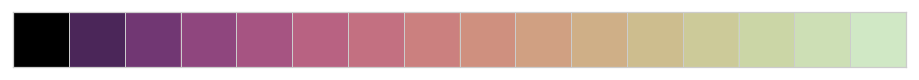

In [44]:
cmap_phoenix = sns.palplot(sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=1, dark=0, light=.75, reverse=True))

#### Display the colormap:

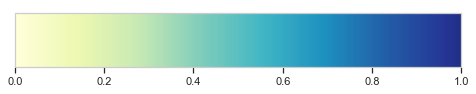

In [520]:
cmap = cmap_light
fig=plt.figure(figsize=(8,1))
ax=fig.add_subplot(111)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                #norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]
                              )
plt.show()

## Set parameters for wordcloud


These variables determine:
* (tokenized) word set
* output file to save word cloud to
* image file to use as mask

In [530]:
text = " ".join(janet_doe_wRT)
wordle_output_gif = "twitter_clouds/mla19_tweets_janetdoe_may6_sml.png"
mask_image = "twitter_masks/Jerry_at_lectern.jpg"
cmap = cmap_janetdoe

## Generate word cloud

In [531]:
# create image mask
# Colored areas of the image will be where words get placed. White areas will be left blank
mask = np.array(Image.open(mask_image))

# set some colors:
MLAGREEN = '#00A09C'
SUNLIGHT = '#FFE563'
IMPROVRED = '#FA3928'
background_color = 'white'

# initialize word cloud generator:
wc = WordCloud(mask=mask,
               font_path="/System/Library/Fonts/SFCompactDisplay-Bold.otf",
               background_color=background_color, 
               colormap=cmap,
               stopwords=get_stopwords(stop_tweeters=True), 
               collocations=False,
               max_words=2000, 
               relative_scaling=0.4,
               width=500, height=500, 
               scale=4   # bigger scale means bigger image rendered. same with width and height
              )

# generate word cloud
wc.generate(text);

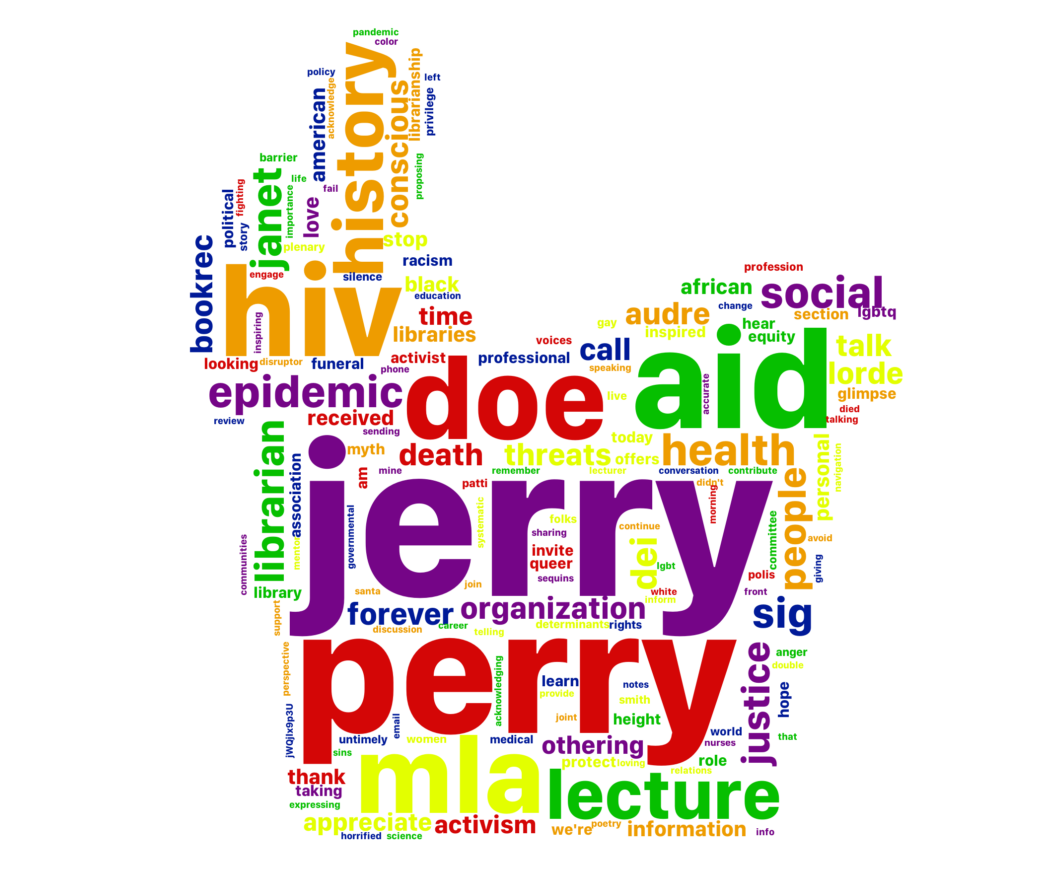

<Figure size 720x720 with 0 Axes>

In [532]:
# show word cloud
plt.figure(figsize=(18,18))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(10,10))
plt.show();

In [533]:
# store to file
wc.to_file(wordle_output_gif);

### Create second wordcloud for dual-image

In [320]:
wc2 = WordCloud(mask=np.array(Image.open("twitter_masks/chicago_skyline_at_right.jpg")),
               font_path="/System/Library/Fonts/SFCompactDisplay-Bold.otf",
               background_color="navy", 
               colormap=cmap_elevate,
               stopwords=get_stopwords(stop_tweeters=True), collocations=False,
               max_words=2000, relative_scaling=0.4,
               width=500, height=500, scale=4   # bigger scale means bigger image rendered. same with width and height
              )
# generate word cloud
wc2.generate(" ".join(after_hours_wRT));

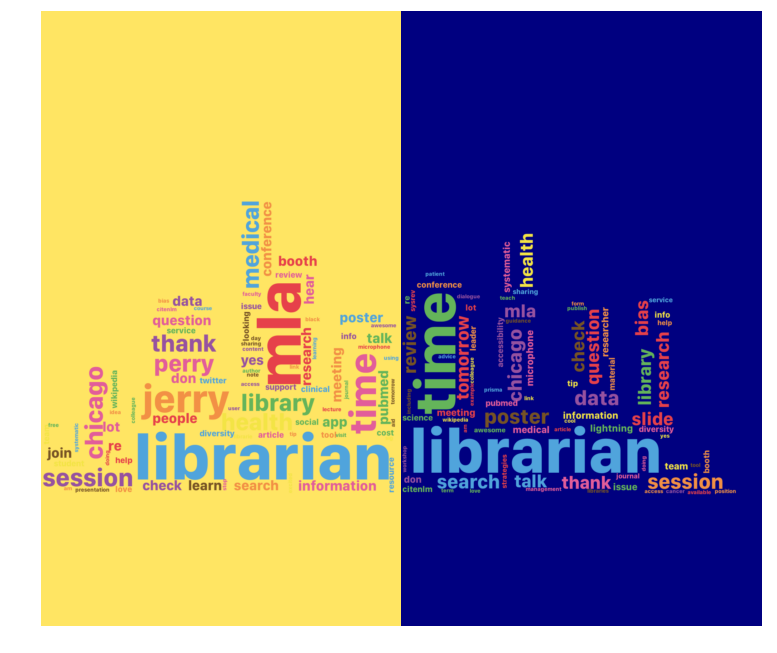

In [325]:
# show two figures side by side:
#fig = plt.figure(figsize=(10,9))
#ax1 = fig.add_subplot(121, )
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(10,9))
fig.subplots_adjust(0,0,1,1,0,0)

axes[0].imshow(wc, interpolation='bilinear')
axes[0].axis("off")

#ax2 = fig.add_subplot(122)
axes[1].imshow(wc2, interpolation='bilinear')
axes[1].axis("off")

fig.subplots_adjust(wspace=0)
#plt.tight_layout()
plt.savefig("twitter_clouds/night_and_day.png", transparent=True)
plt.show()

### Look at the top 50 words

In [52]:
# provides a sorted list of words and their frequencies
top50 = sorted(wc.words_.items(), key=lambda x: x[1], reverse=True)

In [53]:
refactored=list(zip(*top50))
s_wordfreq = pd.Series(data=refactored[1], index=refactored[0])

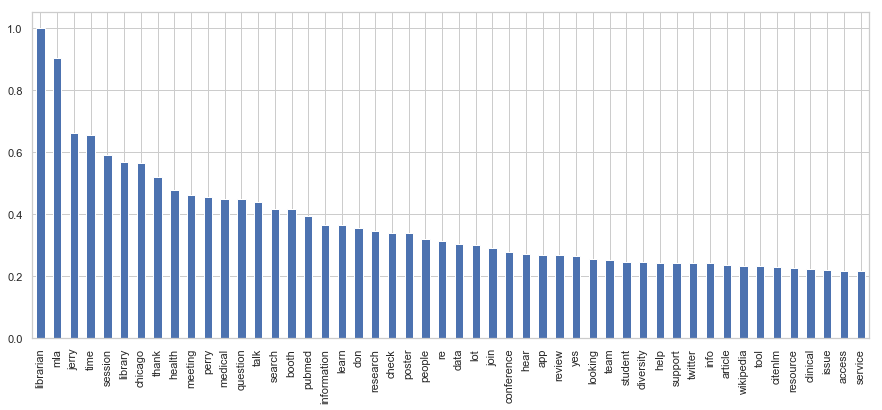

In [54]:
s_wordfreq[:50].plot.bar(figsize=(15,6))

---
---
# Appendix 1
## analysis of communication between members
*using mentions of twitter handles to build network of communication*


In [55]:
tweets["handles"] = tweets["tknzd"].apply(lambda x: [t for t in x if t[0] == "@" and len(t) > 1])

This next step was tricky, because the apply function could not receive the raw list, without it matching the shape of the original dataframe. The answer turned out to be, convert the list into a series with a single index, and return that instead. 

The following cell looks for twitter handles in the tokenized tweets, and creates a list of tuples - each tuple containing the tweeting handle, followed by the handle they mentioned.

In [56]:
def join_users(s):
    #print(s)
    
    results = []
    for h in s["handles"]:
        results.append(("@" + s["user.screen_name"], h))
    results = results
    #print( results)
    #print("#" * 12)
    return pd.Series({"results":results})
                     
tweets["connections"] = tweets.apply(join_users, axis=1)

In [57]:
# print to csv:
pairs = [ t for l in tweets.connections.values for t in l]
cnt = Counter(pairs)

In [58]:
df_network = pd.DataFrame({'sender':[key[0] for key,val in cnt.items() ],
                          'receiver':[key[1] for key,val in cnt.items() ],
                          'dist':[val for key,val in cnt.items() ],
                         })
df_network.to_csv("twitter_connections.csv", index=False)
df_network.head()

,sender,receiver,dist
0,@runwallergies,@krafty,1
1,@ChrisTheCat,@lesliegscn,1
2,@shdejones,@itskelsab,2
3,@TBrigham,@itskelsab,4
4,@TBrigham,@fhslaorg,8


In [59]:
df_net_pivot = df_network.pivot_table(values='dist', index='receiver', columns='sender')

In [60]:
label_union = df_net_pivot.index.union(df_net_pivot.columns)
df_net_pivot = df_net_pivot.reindex(index=label_union, columns=label_union)
df_net_pivot = df_net_pivot.fillna(0)

This is a very sparse matrix!!!

In [61]:
import networkx as nx

In [62]:
G = nx.from_pandas_adjacency(df_net_pivot)

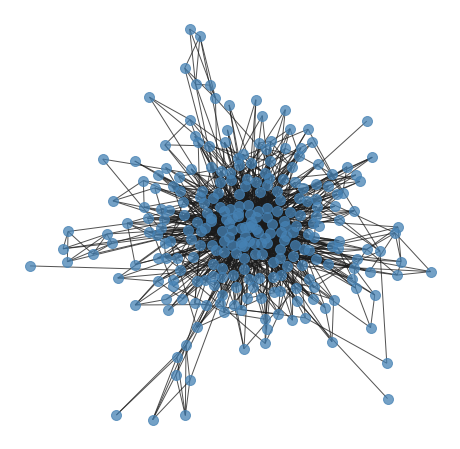

In [63]:
fig, ax = plt.subplots(1, 1,figsize=(8,8))
#nx.draw(G, pos=nx.spring_layout(G, k=1/10), node_size=100, alpha=0.75, node_color='steelblue')
#nx.draw_networkx()
Gs = G.subgraph([n for n in G if G.degree(n)>3])
nx.draw(Gs, pos=nx.spring_layout(Gs, k=1/5), node_size=100, alpha=0.75, node_color='steelblue')

In [64]:
plt.savefig("twitter_analysis/twitter_interactions_all_spring_may7.png", transparent=True)

<Figure size 432x288 with 0 Axes>

In [65]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [66]:
tweet_analysis = tweet_analysis.reset_index()
tweet_analysis['handle_upper'] = tweet_analysis['user.screen_name'].apply(lambda x: x.upper())
tweet_analysis = tweet_analysis.set_index('handle_upper')

In [67]:
import umap

In [68]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.2,
                      metric='euclidean').fit_transform(df_net_pivot)

### create embeddings dataframe
This now combines the embedding coords with the tweet data, allowing fancy graphing

In [69]:
df_embeddings = pd.DataFrame(data=embedding, index=df_net_pivot.index
                            ).rename(columns={0:'x', 1:'y'}
                            ).reset_index()
df_embeddings['handle_upper'] = df_embeddings['index'].apply(lambda x: x.upper()[1:])

# merge embedding coords with tweet analysis data
df_embeddings = df_embeddings.join(tweet_analysis, on='handle_upper', 
                                   lsuffix='_embed', rsuffix='_anal'
                                  )

# remove individuals tweeted at which haven't also tweeted with #mlanet19
df_embeddings = df_embeddings.dropna()

# remove people who have changed their name slightly, and thus appear twice!
df_embeddings = df_embeddings.drop_duplicates(subset=['handle_upper'])

# create column showing proportion of tweets that are original
df_embeddings['original_ratio'] = df_embeddings.is_original / df_embeddings.total_tweets

In [70]:
df_embeddings.head(3)

,index,x,y,handle_upper,user.screen_name,retweet_mean,favorite_mean,creation_hour,total_tweets,is_retweet,is_reply,is_original,original_ratio
0,@123POW,10.281685,10.375864,123POW,123POW,2.062500,13.875,14.500000,16.0,2.0,1.0,13.0,0.812500
2,@724PhillipsK,10.578642,12.389009,724PHILLIPSK,724PhillipsK,6.666667,4.000,13.333333,3.0,1.0,0.0,2.0,0.666667
5,@ABannachBrown,12.119839,12.736600,ABANNACHBROWN,ABannachBrown,25.000000,0.000,0.000000,1.0,1.0,0.0,0.0,0.000000


## K-means clustering of tweeters

In [71]:
from sklearn.cluster import KMeans

In [72]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(df_embeddings[['x','y']].values)
Z = kmeans.predict(df_embeddings[['x','y']].values)

In [73]:
centroids = pd.DataFrame(kmeans.cluster_centers_, index=[0,1,2,3,4,5])

In [74]:
df_embeddings['kmeans_cluster'] = pd.DataFrame(Z, index=df_embeddings.index)

### get group leaders
For cluster presentation, we want to find the top three most prolific tweeters for each group. 

In [75]:
df_grp_leaders = df_embeddings.sort_values(["kmeans_cluster", "total_tweets"], ascending=False
                             ).groupby('kmeans_cluster'
                             ).agg({"total_tweets":lambda s: list(s[:3]),
                                    "index":lambda s: list(s[:3]),
                                   })
df_grp_leaders

,total_tweets,index
kmeans_cluster,,
0,"[56.0, 41.0, 40.0]","[@noisy_nora, @krafty, @sarahclarke138]"
1,"[145.0, 94.0, 82.0]","[@EMorETon47, @ChrisTheCat, @ChelseaMisquith]"
2,"[62.0, 53.0, 43.0]","[@angspenc, @oponiak, @openpeonie]"
3,"[202.0, 108.0, 31.0]","[@VPannabecker, @TBrigham, @VisualDx]"
4,"[423.0, 368.0, 247.0]","[@pfanderson, @hurstej, @akaur0]"
5,"[34.0, 21.0, 15.0]","[@mbbassdrlib, @lisalibrarian, @alexjcarroll]"


In [76]:
grp_leaders = [ u  for grp in df_grp_leaders['index'].values for u in grp ]

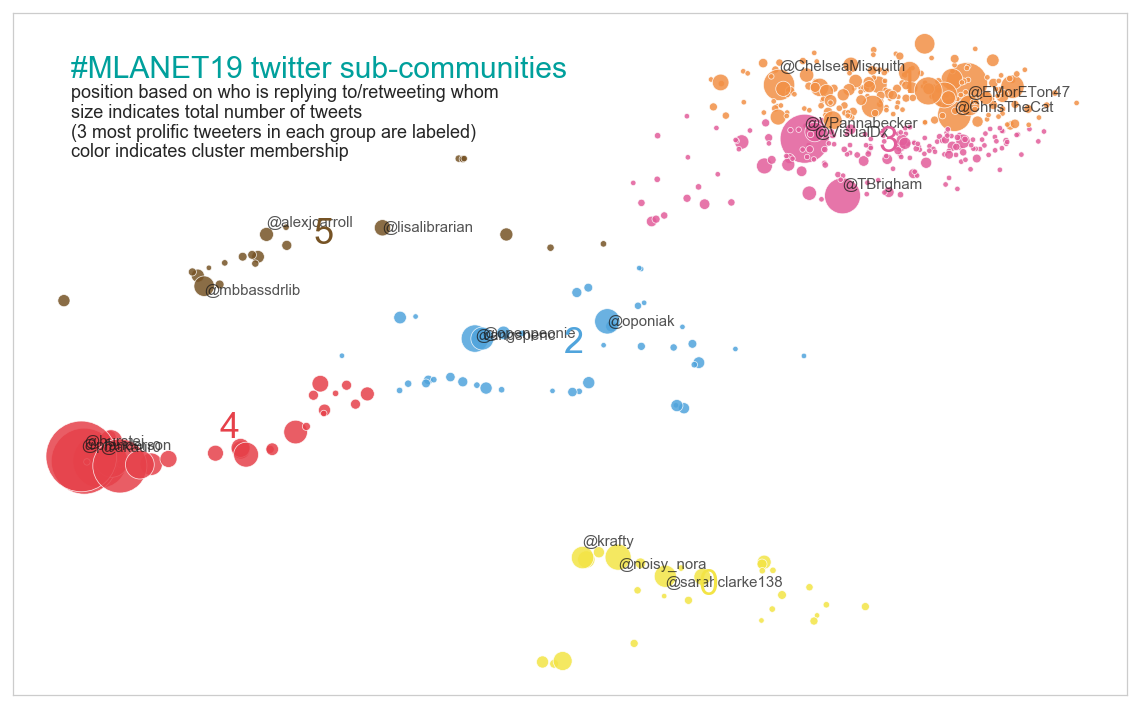

In [82]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(data=df_embeddings,
                x='x', y='y',
                hue='kmeans_cluster',  # also can use 'original_ratio'
                size='total_tweets',
                sizes=(30,5000),  # min and max size of circles
                palette=cmap_elevate,
                alpha=0.85,
                ax=ax,
                legend=None,
               )

# add handles for most prolific tweeters
for idx in df_embeddings[df_embeddings['index'].isin(grp_leaders)].index:
    plt.text(x=df_embeddings.loc[idx,'x'], 
             y=df_embeddings.loc[idx,'y'] + (np.random.rand(1) - 0.5)/1.25, 
             s=df_embeddings.loc[idx,'index'],
             color='k', #plt.cm.winter(np.log(df_net_pivot.iloc[i,:].sum()+1) / 6),
             alpha=0.75,
             fontdict={'size': 15}
            )

text_x = 5
header_y = 12
plt.text(text_x,header_y,"#MLANET19 twitter sub-communities", fontsize=30, color=MLAGREEN) 
plt.text(text_x,header_y-0.5,"position based on who is replying to/retweeting whom", fontsize=18)
plt.text(text_x,header_y-1,"size indicates total number of tweets", fontsize=18)
plt.text(text_x,header_y-1.5,"(3 most prolific tweeters in each group are labeled)", fontsize=18)
plt.text(text_x,header_y-2,"color indicates cluster membership", fontsize=18)

# plot centroids
for grp in centroids.index:
    plt.text(centroids.loc[grp,0], centroids.loc[grp,1], str(grp), fontsize=36, color=cmap_elevate(grp/5))

plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")

#plt.legend()   #loc=(1.1,0.1)

plt.tight_layout()
plt.savefig("twitter_analysis/twitter_subcommunities_may07.png", transparent=True)
plt.show()

### Create Bokeh plot 

In [83]:
bokeh_data = df_embeddings.copy()
bokeh_data['size'] = bokeh_data.total_tweets.apply(lambda x: np.log10(x)/10)
bokeh_data['fill'] = bokeh_data.kmeans_cluster.apply(lambda x: mpl.colors.rgb2hex(cmap_elevate(x/5)[:3]))
bokeh_data.head()

,index,x,y,handle_upper,user.screen_name,retweet_mean,favorite_mean,creation_hour,total_tweets,is_retweet,is_reply,is_original,original_ratio,kmeans_cluster,size,fill
0,@123POW,10.281685,10.375864,123POW,123POW,2.062500,13.875,14.500000,16.0,2.0,1.0,13.0,0.812500,3,0.120412,#e25d9a
2,@724PhillipsK,10.578642,12.389009,724PHILLIPSK,724PhillipsK,6.666667,4.000,13.333333,3.0,1.0,0.0,2.0,0.666667,1,0.047712,#f29045
5,@ABannachBrown,12.119839,12.736600,ABANNACHBROWN,ABannachBrown,25.000000,0.000,0.000000,1.0,1.0,0.0,0.0,0.000000,1,0.000000,#f29045
6,@AESSnews,10.040317,11.960580,AESSNEWS,AESSnews,0.000000,6.000,17.000000,1.0,0.0,0.0,1.0,1.000000,1,0.000000,#f29045
7,@AGlusker,10.763274,12.427443,AGLUSKER,AGlusker,2.666667,0.000,16.000000,3.0,3.0,0.0,0.0,0.000000,1,0.047712,#f29045


In [84]:
# output to static HTML file
bplt.output_notebook()
bplt.output_file("twitter_graphs/subcommunities_bokeh_may7.html", 
                 title='Twitter subcommunities of #mlanet19'
                )

# define data source
source = ColumnDataSource(data=bokeh_data)

# define hover output:
hover = HoverTool(tooltips=[("","@index",),
                            ("mean time of day", "@creation_hour"),
                            ("total tweets", "@total_tweets"),
                            ("original", "@is_original"),
                            ("replies", "@is_reply"),
                            ("retweets", "@is_retweet"),
                            ],
                  #mode='vline',
                  #names=['Retweets']
                 )

#TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
TOOLS = ["pan","zoom_in", "zoom_out","box_zoom","reset", hover,  "crosshair", "save", ]

p = bplt.figure(plot_height=600, 
                plot_width=1200, 
                #x_range=bokeh_data["user.screen_name"].values,
                tools=TOOLS,
               )

p.scatter(x='x', y='y', 
          radius='size',
          fill_color='fill', #df_embeddings.kmeans_cluster.apply(lambda x: cmap_elevate(x/5)), 
          source=source,
          fill_alpha=0.6,
          line_color=None,
         )

#p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)

#p.xaxis.major_label_orientation = pi/4

# show the results
bplt.show(p)

Loading BokehJS ...

### Get topics of each community
For this purpose, we are removing the users handles and hashtags

In [85]:
tweets["tknzd_cleaned"
      ] = tweets.tknzd.apply(lambda x: [w for w in x if (
                                                (w not in get_stopwords()) &
                                                (bool(re.search("\w", w))) 
                                                        ) 
                                       ])

tweets["tknzd_no_users"
      ] = tweets.tknzd_cleaned.apply(lambda x: [w for w in x if w[0] != '@'])

tweets["tknzed_no_hashusers"
      ] = tweets.tknzd_no_users.apply(lambda x: [w for w in x if w[0] != '#'])


Here we now merge the community cluster identification of each user with the list of all tweets, allowing each tweet to be assigned a cluster based on where its user is located.

In [86]:
df_community = pd.merge(df_embeddings, tweets,
                        on='user.screen_name',
                        how='left',
                       )

In [87]:
df_community[['user.screen_name', 'kmeans_cluster', 'tknzed_no_hashusers']].head()

,user.screen_name,kmeans_cluster,tknzed_no_hashusers
0,123POW,3,"[awesome, using, platforms]"
1,123POW,3,"[evening, shenanigans, https://t.co/w3iI3dc6kx]"
2,123POW,3,"[correct, link, slides, https://t.co/XHV6Pfryk..."
3,123POW,3,"[stoked, hear, uta's, data, cave, lightning, t..."
4,123POW,3,"[giving, lightning, talk, library, data, analy..."


In [88]:
df_community_wordset =  df_community.groupby('kmeans_cluster'
                                   ).agg({"tknzed_no_hashusers":lambda l: [ w for subset in l for w in subset ]})

In [89]:
df_community_wordset['counter'] = df_community_wordset.tknzed_no_hashusers.apply(lambda x: Counter(x))

In [90]:
df_community_wordset['top_10'] = df_community_wordset.counter.apply(lambda x: x.most_common(n=10))

In [91]:
df_community_wordset['top_10']

kmeans_cluster
0    [(mla, 22), (health, 20), (library, 16), (meet...
1    [(mla, 70), (session, 61), (time, 61), (librar...
2    [(mla, 19), (jerry, 16), (chicago, 16), (libra...
3    [(mla, 57), (booth, 45), (session, 36), (jerry...
4    [(jerry, 86), (mla, 84), (pubmed, 75), (time, ...
5    [(talk, 12), (mla, 10), (librarians, 9), (chic...
Name: top_10, dtype: object

In [92]:
top_10 = df_community_wordset['top_10'].values

In [93]:
 df_top_10 = pd.DataFrame({ i:dict(tt) for i,tt in enumerate(top_10) })

In [94]:
df_tt_stack = pd.DataFrame(df_top_10.stack()
                          ).reset_index(
                          ).rename(columns={"level_0":'word',
                                            "level_1":'community',
                                            0:'wordcount',
                                           })

In [95]:
df_tt_sum = df_tt_stack.groupby('community').sum()

In [96]:
df_tt_stack = df_tt_stack.join(df_tt_sum, on='community', 
                               lsuffix='_stack', rsuffix='_sum')

In [97]:
df_tt_stack['wordfreq'] = df_tt_stack.wordcount_stack / df_tt_stack.wordcount_sum

In [98]:
df_tt_stack.head()

,word,community,wordcount_stack,wordcount_sum,wordfreq
0,afternoon,5,5.0,79.0,0.063291
1,booth,1,47.0,546.0,0.086081
2,booth,3,45.0,358.0,0.125698
3,check,3,30.0,358.0,0.083799
4,chicago,0,15.0,149.0,0.100671


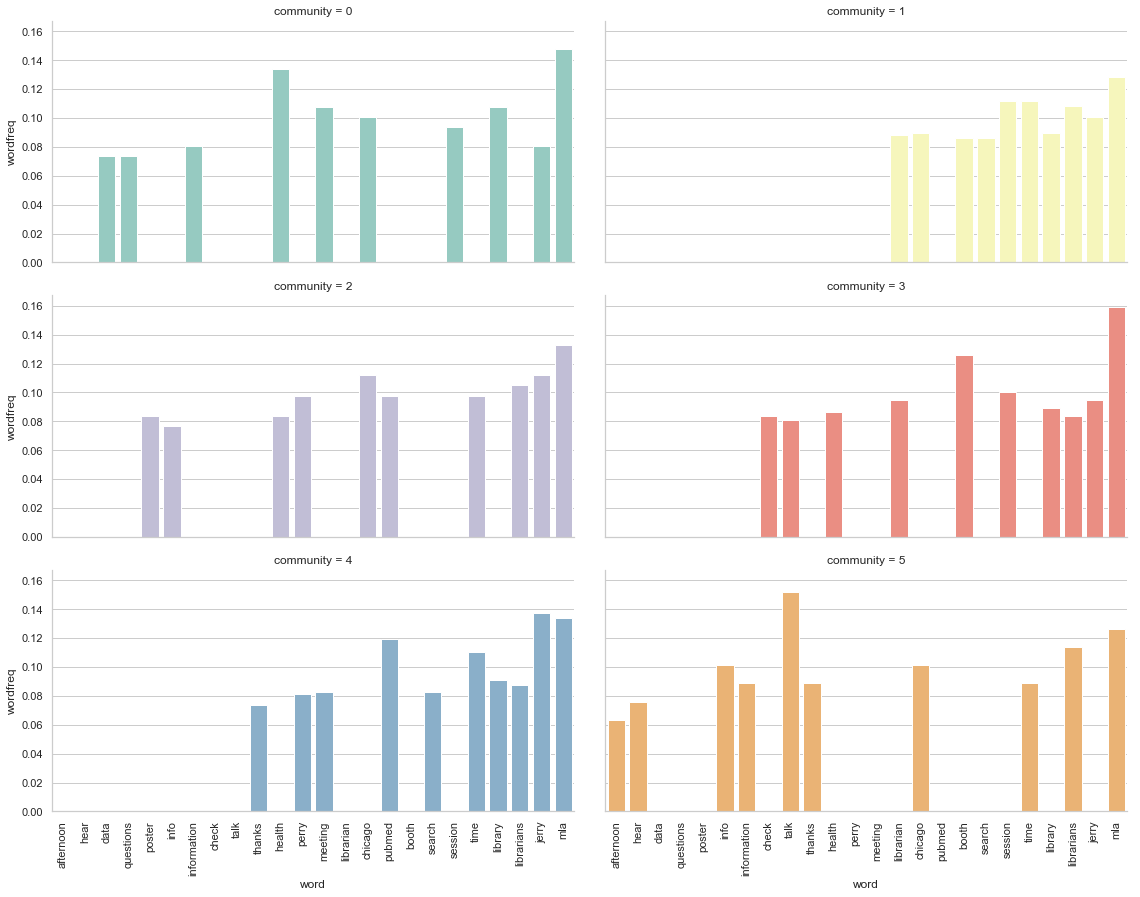

In [99]:
word_order = df_top_10.sum(axis=1).sort_values().index #df_tt_stack.word.unique()
g = sns.FacetGrid(df_tt_stack, col="community", col_wrap=2, 
                  hue="community",
                  palette="Set3", 
                  height=4, aspect=2)
g.map(sns.barplot, 'word', 'wordfreq', order=word_order)
g.set_xticklabels(rotation=90)
plt.show()

# Topic Modelling

## LDA analysis
_from WikiPedia:_

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's creation is attributable to one of the document's topics. LDA is an example of a topic model and was first presented as a graphical model for topic discovery by David Blei, Andrew Ng, and Michael I. Jordan in 2003. Essentially the same model was also proposed independently by J. K. Pritchard, M. Stephens, and P. Donnelly in the study of population genetics in 2000. Both papers have been highly influential, with 16488 and 18170 citations respectively by December 2016.

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

we need to create a matrix of tokens and their counts for each tweet. During this creation process, the LDA example eliminates words present in > 95% of articles, or less than 2 articles.

We also need to clean the word set for stop words.

In [154]:
tweets.head()

,created_at,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,retweeted,text,truncated,user.id,user.screen_name,tknzd,tknzd_cleaned
id,,,,,,,,,,,,
1125473150207188992,2019-05-06 14:51:23+00:00,0,NaN,NaN,0,False,CKM’s @Taneya giving talk at 2pm in Columbus R...,False,748973663517609985,VUMCKnowMgt,"[ckm, ’, s, @taneya, giving, talk, at, 2pm, in...","[ckm, @taneya, giving, talk, 2pm, columbus, tr..."
1125472447321575424,2019-05-06 14:48:36+00:00,0,NaN,NaN,3,False,RT @LibrarianLizy: This grumbling and complain...,False,41206643,mandosally,"[rt, @librarianlizy, :, this, grumbling, and, ...","[@librarianlizy, grumbling, complaining, accom..."
1125472291926761473,2019-05-06 14:47:59+00:00,0,NaN,NaN,0,False,"Bring your questions, comments and suggestions...",True,3331772009,ItsKelsaB,"[bring, your, questions, ,, comments, and, sug...","[bring, questions, comments, suggestions, dive..."
1125471492895121413,2019-05-06 14:44:48+00:00,0,NaN,NaN,0,False,Come to the diversity roundtable tonight and l...,False,287273757,jjpionke,"[come, to, the, diversity, roundtable, tonight...","[diversity, roundtable, tonight, let's, talk, ..."
1125471199532933121,2019-05-06 14:43:38+00:00,2,NaN,NaN,0,False,Interested in creating a disability sig/caucus...,True,287273757,jjpionke,"[interested, in, creating, a, disability, sig,...","[creating, disability, sig, caucus, diversity,..."


In [155]:
tokenset = tweets.tknzd_cleaned.reset_index()
s = tokenset.apply(lambda x: pd.Series(x['tknzd_cleaned']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'tkns'
tokendf = tokenset.drop('tknzd_cleaned', axis=1).join(s)
tokendf["present"] = 1
print(tokendf.shape)
tokendf.head()

(32736, 3)


,id,tkns,present
0,1125473150207188992,ckm,1
0,1125473150207188992,@taneya,1
0,1125473150207188992,giving,1
0,1125473150207188992,talk,1
0,1125473150207188992,2pm,1


In [ ]:
tweetarray = pd.pivot_table(tokendf.reset_index(), index='id', columns='tkns', values='present', )
tweetarray = tweetarray.fillna(0)
print(tweetarray.shape)
tweetarray = tweetarray[[x for x in tweetarray.columns if (
                                            tweetarray[x].sum() > 1
                                                        ) & (
                                            tweetarray[x].sum() < 0.95 * len(tweetarray[x])
                                                        ) ]]
print(tweetarray.shape)
tweetarray.head()

In [ ]:
%%time
lda = LatentDirichletAllocation(n_topics=20, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tweetarray)

feature_names = tweetarray.columns

In [ ]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
print_top_words(lda, feature_names)

To assign each tweet to one of the groups, transform the tweet array using the LDA model, which provides the assignment score for each group for each tweet.

In [ ]:
tr_tweetarray = lda.transform(tweetarray)

In [ ]:
tr_tweetarray.shape

In [ ]:
assignmentdf = pd.DataFrame(tr_tweetarray)
assignmentdf["best"] = assignmentdf.idxmax(axis=1)
assignmentdf["tweet"] = tweetarray.index
assignmentdf = assignmentdf.set_index("tweet")
assignmentdf.head()

In [ ]:
assignmentdf["gt_02"] = assignmentdf[assignmentdf > 0.2].count(axis=1)

In [ ]:
assignmentdf["gt_02"].describe()

In [ ]:
handle = open("twitter_distances.txt", 'w')
for topic in assignmentdf.columns[:-1]:
    for tweet in assignmentdf[topic].index:
        handle.write("%s,%s,%.6f\n" % (topic, tweet, assignmentdf[topic][tweet]))
handle.close()

In [ ]:
for x in assignmentdf[0].index[:10]:
    print(assignmentdf[0][x])

## Doc2Vec

### gather larger corpus from twitterverse for training
because of the small number of tweets, we should find and use a larger but related corpus of tweets. The #medlibs hashtag has even fewer tweets availabile to utilize. 

In [ ]:
oauth = credsfromfile()
client = Query(**oauth)
tweets_medlibs = client.search_tweets(keywords='#medlibs', 
                              limit=10000)

medlibs_json = "tweets_medlibs.json"

handle = open(medlibs_json, 'w')
for i,t in enumerate(tweets_medlibs):
    handle.write(json.dumps(t) + '\n')
handle.close()
print(i, "tweets written to {}".format(medlibs_json))

medlibs_metadata_file = 'tweets_medlibs_metadata.csv'
with open(medlibs_json) as fp:
    json2csv(fp, tweet_metadata_file,
            ['created_at', 'favorite_count', 'id', 'in_reply_to_status_id', 
            'in_reply_to_user_id', 'retweet_count', 'retweeted', 
            'text', 'truncated', 'user.id', 'user.screen_name'])

df_medlib_tweets = pd.read_csv(tweet_metadata_file, index_col=2, header=0, encoding="utf8")

# adjust to local time (time reported is UTC)
df_medlib_tweets.created_at = pd.to_datetime(df_medlib_tweets.created_at) - pd.DateOffset(hours=4) 
df_medlib_tweets.head(3)

### Import Doc2Vec modules

In [104]:
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument, TaggedLineDocument

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [105]:
import smart_open

In [106]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), 
                                                           [i]
                                                          )
                

In [157]:
def read_corpus_df(df, tokens_only=False, column='tknzd_cleaned'):
    for idx, (twid, text) in enumerate(zip(df.index, 
                                           df[column].apply(lambda x: " ".join(x)
                                                    ).values
                                          )):
        if tokens_only:
            yield gensim.utils.simple_preprocess(text)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(text), 
                                                       [idx]
                                                      )

### Generate model

In [159]:
docs = list(read_corpus_df(tweets, column='tknzed_no_hashusers'))
print(len(docs))

4759


In [160]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=75,     # dimensionality of feature vectors
                                      min_count=2, # ignore words with this freq or lower
                                      epochs=55,   # number of iterations over the columns
                                     )

In [161]:
%%time
# build vocabulary:
model.build_vocab(docs)

CPU times: user 175 ms, sys: 13.4 ms, total: 188 ms
Wall time: 204 ms


In [162]:
%%time 
# train model
model.train(docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs,
           )

CPU times: user 9.19 s, sys: 1.99 s, total: 11.2 s
Wall time: 7.84 s


In [163]:
doc_dir = "twitter_analysis"

In [164]:
model.save(os.path.join(doc_dir, "model.mdl"))

In [165]:
model = Doc2Vec.load(os.path.join(doc_dir, "model.mdl"))

### Kmeans Clustering of tweets

In [166]:
# doc_tags = list(model.docvecs.doctags.keys())
X = model[np.arange(0,len(docs))]

In [167]:
X.shape

(4759, 75)

#### Calculate the optimal number of clusters
Using the Silhouette model

In [246]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [249]:
range_n_clusters = np.arange(2,60,2)
dict_silhouette = {}
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    #print("{} clusters: {}".format(n_clusters, silhouette_avg))
    dict_silhouette[n_clusters] = silhouette_avg
    #sample_silhouette_values = silhouette_samples(X, cluster_labels)


2 clusters: 0.11344165354967117
4 clusters: 0.04764186963438988
6 clusters: 0.045042987912893295
8 clusters: 0.029343798756599426
10 clusters: 0.029125751927495003
12 clusters: 0.024465732276439667
14 clusters: 0.009697114117443562
16 clusters: 0.011697497218847275
18 clusters: 0.010397330857813358
20 clusters: 0.020067352801561356
22 clusters: 0.009703090414404869
24 clusters: 0.02391703426837921
26 clusters: 0.014841309748589993
28 clusters: 0.01530816126614809
30 clusters: 0.02259502373635769
32 clusters: 0.0218526478856802
34 clusters: 0.016103697940707207
36 clusters: 0.01754634827375412
38 clusters: 0.016985971480607986
40 clusters: 0.03193080052733421
42 clusters: 0.014145372435450554
44 clusters: 0.03504331782460213
46 clusters: 0.019849061965942383
48 clusters: 0.022798484191298485
50 clusters: 0.019528964534401894
52 clusters: 0.03140031173825264
54 clusters: 0.03877792879939079
56 clusters: 0.023286690935492516
58 clusters: 0.024303961545228958


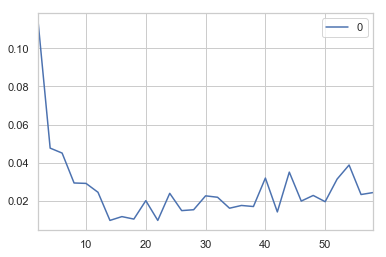

In [251]:
df_silhouette = pd.DataFrame(dict_silhouette.values(), index=dict_silhouette.keys())
df_silhouette.plot()

#### get values for the optimal cluster size

In [252]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)
Z = kmeans.predict(X)

In [253]:
centroids = pd.DataFrame(kmeans.cluster_centers_, index=np.arange(0,n_clusters))

In [254]:
df_tweet_clusters = pd.DataFrame(Z, index=tweets.index)

In [255]:
df_tweet_clusters.head()

,0
id,
1125773666917261313,0
1125773625943109632,3
1125773623858487300,2
1125773593391054849,4
1125773509513424897,1


### View the 'topics' of each cluster
To do this (crudely), we can just pull the list of words present in each cluster, and see which ones are most predominant

In [256]:
df_tweet_clusters = df_tweet_clusters.join(tweets[["tknzed_no_hashusers",
                                                   "user.screen_name", 
                                                   "is_retweet", 
                                                   "is_reply", 
                                                   "creation_hour", ]]
                                          ).rename(columns={0:"kmeans_cluster"})

In [257]:
df_tweet_clusters.head()

,kmeans_cluster,tknzed_no_hashusers,user.screen_name,is_retweet,is_reply,creation_hour
id,,,,,,
1125773666917261313,0,"[unfortunately, lib, school, students, school,...",runwallergies,True,False,10
1125773625943109632,3,"[happy, doing, public, setting, instead, https...",ChrisTheCat,False,True,10
1125773623858487300,2,"[congratulations, kelsa, bartley, selected, ml...",shdejones,False,False,10
1125773593391054849,4,"[woo, hoo, congratulations, becoming, congr, h...",TBrigham,False,False,10
1125773509513424897,1,"[publish, search, strategies, check, draft, pr...",uct_hsl,True,False,10


In [258]:
df_tweet_wordset =  df_tweet_clusters.groupby('kmeans_cluster'
                                   ).agg({"tknzed_no_hashusers":lambda l: [ w for subset in l for w in subset ],

                                         })


In [259]:
df_tweet_wordset.head()

,tknzed_no_hashusers
kmeans_cluster,
0,"[unfortunately, lib, school, students, school,..."
1,"[publish, search, strategies, check, draft, pr..."
2,"[congratulations, kelsa, bartley, selected, ml..."
3,"[happy, doing, public, setting, instead, https..."
4,"[woo, hoo, congratulations, becoming, congr, h..."


In [260]:
df_tweet_wordset['counter'] = df_tweet_wordset.tknzed_no_hashusers.apply(lambda x: Counter(x))

In [261]:
df_tweet_wordset['top_15'] = df_tweet_wordset.counter.apply(lambda x: x.most_common(n=15))

In [262]:
df_tweet_wordset['top_15']

kmeans_cluster
0    [(librarians, 140), (health, 92), (medical, 84...
1    [(mla, 112), (booth, 103), (chicago, 99), (tim...
2    [(mla, 68), (meeting, 53), (diversity, 52), (q...
3    [(session, 45), (mla, 36), (time, 36), (people...
4    [(jerry, 172), (perry, 112), (lecture, 51), (a...
5    [(search, 116), (pubmed, 81), (check, 58), (te...
Name: top_15, dtype: object

In [263]:
tweet_clusters_top_15 = df_tweet_wordset['top_15'].values

In [264]:
 df_cluster_topics = pd.DataFrame({ i:dict(tt) for i,tt in enumerate(tweet_clusters_top_15) })

In [265]:
df_ct_stack = pd.DataFrame(df_cluster_topics.stack()
                          ).reset_index(
                          ).rename(columns={"level_0":'word',
                                            "level_1":'community',
                                            0:'wordcount',
                                           })

In [266]:
df_ct_sum = df_ct_stack.groupby('community').sum()

In [267]:
df_ct_stack = df_ct_stack.join(df_ct_sum, on='community', 
                               lsuffix='_stack', rsuffix='_sum')

In [268]:
df_ct_stack['wordfreq'] = df_ct_stack.wordcount_stack / df_ct_stack.wordcount_sum

In [269]:
df_ct_stack.sort_values('community', ascending=False).head(10)

,word,community,wordcount_stack,wordcount_sum,wordfreq
79,terms,5,31.0,570.0,0.054386
18,don,5,23.0,570.0,0.040351
61,pubmed,5,81.0,570.0,0.142105
59,publish,5,24.0,570.0,0.042105
58,prisma-s,5,24.0,570.0,0.042105
57,poster,5,26.0,570.0,0.045614
73,strategies,5,29.0,570.0,0.050877
67,search,5,116.0,570.0,0.203509
80,text,5,29.0,570.0,0.050877
23,guidance,5,26.0,570.0,0.045614


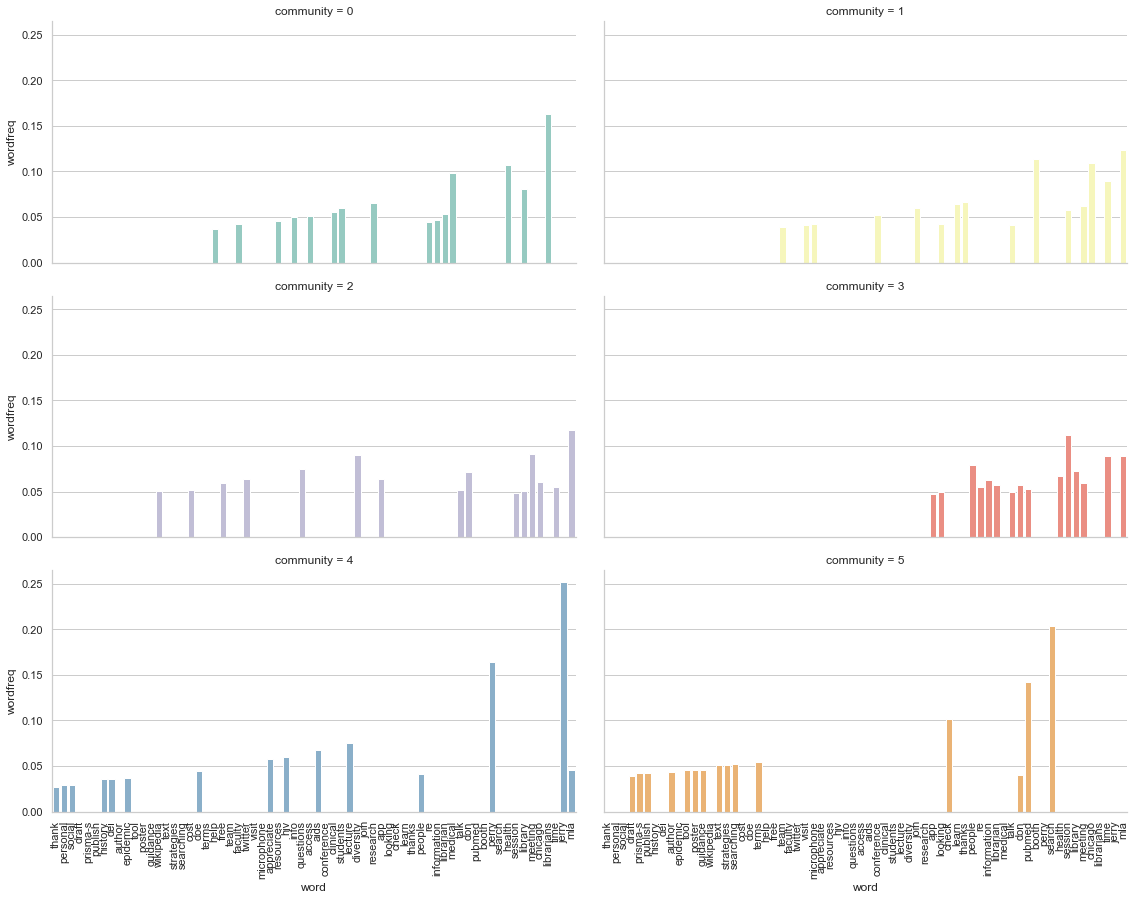

In [272]:
word_order = df_cluster_topics.sum(axis=1).sort_values().index #df_tt_stack.word.unique()
g = sns.FacetGrid(df_ct_stack, col="community", col_wrap=2, 
                  hue="community",
                  palette="Set3", 
                  height=4, aspect=2)
g.map(sns.barplot, 'word', 'wordfreq', order=word_order)
g.set_xticklabels(rotation=90)
plt.savefig("twitter_graphs/tweet_cluster_topics.png")
plt.show()

In [271]:
for cid,clust in enumerate(df_tweet_wordset['top_15'].values):
    total_words = np.sum([ c  for w,c in clust ])
    print("#### {} ({}) ####".format(cid, total_words))
    print(" | ".join([ "{:2d} {:s}".format(c,w)  for w,c in clust ]))

#### 0 (858) ####
140 librarians | 92 health | 84 medical | 69 library | 56 research | 51 students | 48 clinical | 46 librarian | 44 access | 43 info | 40 information | 39 resources | 38 re | 36 faculty | 32 help
#### 1 (907) ####
112 mla | 103 booth | 99 chicago | 81 time | 60 thanks | 58 learn | 56 meeting | 54 join | 52 session | 47 conference | 38 looking | 38 microphone | 37 talk | 37 visit | 35 team
#### 2 (578) ####
68 mla | 53 meeting | 52 diversity | 43 questions | 41 don | 37 twitter | 37 app | 35 chicago | 34 free | 32 time | 30 cost | 30 talk | 29 library | 29 wikipedia | 28 session
#### 3 (402) ####
45 session | 36 mla | 36 time | 32 people | 29 library | 27 health | 25 information | 24 meeting | 23 don | 23 librarian | 22 re | 21 pubmed | 20 looking | 20 talk | 19 app
#### 4 (681) ####
172 jerry | 112 perry | 51 lecture | 46 aids | 41 hiv | 39 appreciate | 31 mla | 30 doe | 28 people | 25 epidemic | 24 history | 24 dei | 20 social | 20 personal | 18 thank
#### 5 (570) ###

### map each user's tweets to the clusters

In [303]:
df_cluster_membership = df_tweet_clusters.groupby(["user.screen_name", 'kmeans_cluster']
                                        ).size(
                                        ).unstack(
                                        ).fillna(0)

In [341]:
umap_tw_membership = umap.UMAP(n_neighbors=80, 
                              min_dist=0.2,
                              #init='random',
                              spread=2.0,
                              metric='euclidean')

In [342]:
tw_mem_embeddings = umap_tw_membership.fit_transform(df_cluster_membership.values)

In [343]:
df_embedding_tweets = pd.DataFrame(tw_mem_embeddings, index=df_cluster_membership.index
                                 ).rename(columns={0:'x',1:'y'}
                                 )

In [344]:
df_cluster_merge = df_embedding_tweets.join(tweet_analysis.set_index('user.screen_name'))
mean_cluster = df_cluster_membership.apply(lambda s: (s[1]+s[2]*2+s[3]*3+s[4]*4+s[5]*5)/s.sum(), 
                                           axis=1
                                    ).rename("mean_cluster")
                           
df_cluster_merge = df_cluster_merge.join(mean_cluster)
df_cluster_merge["cluster_col"
                ] = df_cluster_merge.mean_cluster.apply(lambda x: mpl.colors.rgb2hex(cmap_plasma(x/5)[:3]))
df_cluster_merge.head()

,x,y,retweet_mean,favorite_mean,creation_hour,total_tweets,is_retweet,is_reply,is_original,mean_cluster,cluster_col
user.screen_name,,,,,,,,,,,
123POW,9.846722,-7.146886,2.062500,13.875,14.500000,16,2,1,13,2.000000,#a51f99
724PhillipsK,20.206882,-37.675579,6.666667,4.000,13.333333,3,1,0,2,1.666667,#8f0da4
ABannachBrown,25.354202,-33.675919,25.000000,0.000,0.000000,1,1,0,0,5.000000,#fcce25
AESSnews,18.478437,-42.729359,0.000000,6.000,17.000000,1,0,0,1,2.000000,#a51f99
AGlusker,19.972572,-37.883389,2.666667,0.000,16.000000,3,3,0,0,1.666667,#8f0da4


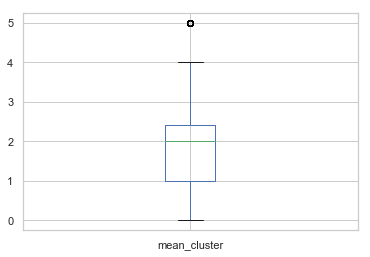

In [347]:
df_cluster_merge.mean_cluster.plot(kind='box')

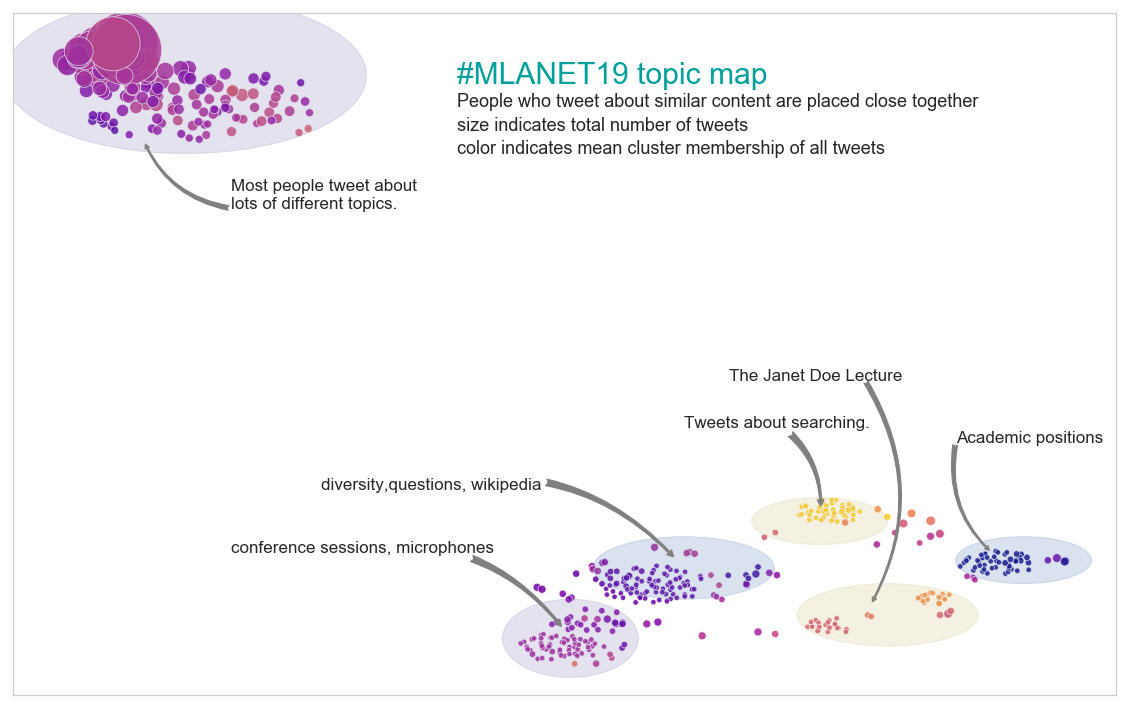

In [396]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(data=df_cluster_merge,
                x='x', y='y',
                hue='mean_cluster',  # also can use 'original_ratio'
                size='total_tweets',
                sizes=(30,5000),  # min and max size of circles
                palette=cmap_plasma,
                alpha=0.85,
                ax=ax,
                legend=None,
                vmin=0,
                vmax=5,
               )

# add title and legend
text_x = 17
header_y = -7
y_spread = 1.5
plt.text(text_x,header_y,"#MLANET19 topic map", fontsize=30, color=MLAGREEN) 
plt.text(text_x,header_y-y_spread,"People who tweet about similar content are placed close together", fontsize=18)
plt.text(text_x,header_y-2*y_spread,"size indicates total number of tweets", fontsize=18)
plt.text(text_x,header_y-3*y_spread,"color indicates mean cluster membership of all tweets", fontsize=18)

# annotate the different clusters
# annotate the large cluster
el = mpl.patches.Ellipse((11, -6.5), 10, 8, angle=90, alpha=0.2, 
                         edgecolor='m', facecolor='m')
ax.add_artist(el)
plt.annotate("",
            xy=(10, -10), xycoords='data',
            xytext=(12, -15), textcoords='data',
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=15,
                            connectionstyle="arc3,rad=-0.3",
                            ),
            )
plt.text(12, -15, "Most people tweet about\nlots of different topics.", fontsize=17)

# annotate the search cluster
el = mpl.patches.Ellipse((25, -35), 3, 3, angle=90, alpha=0.2, 
                         edgecolor='y', facecolor='y')
ax.add_artist(el)
plt.annotate("Tweets about searching.",
            xy=(25, -35), xycoords='data',
            xytext=(22,-29), textcoords='data',
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=15,
                            connectionstyle="arc3,rad=-0.3",
                            ),
             fontsize=17
            )


# annotate the roles cluster
el = mpl.patches.Ellipse((29.5, -37.5), 3, 3, angle=90, alpha=0.2, 
                         edgecolor='b', facecolor='b')
ax.add_artist(el)
plt.annotate("",
            xy=(29, -37.5), xycoords='data',
            xytext=(28,-30), textcoords='data',
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=15,
                            connectionstyle="arc3,rad=0.3",
                            ),
            )
plt.text(28, -30, "Academic positions", fontsize=17)

# annotate the Janet Doe/Jerry Perry cluster
el = mpl.patches.Ellipse((26.5, -41), 4, 4, angle=90, alpha=0.2, 
                         edgecolor='y', facecolor='y')
ax.add_artist(el)
plt.annotate("",
            xy=(26, -41), xycoords='data',
            xytext=(26,-26), textcoords='data',
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=15,
                            connectionstyle="arc3,rad=-0.3",
                            ),
            )
plt.text(23, -26, "The Janet Doe Lecture", fontsize=17)

el = mpl.patches.Ellipse((22, -38), 4, 4, angle=90, alpha=0.2, 
                         edgecolor='b', facecolor='b')
ax.add_artist(el)
plt.annotate("diversity,questions, wikipedia",
            xy=(22, -38), xycoords='data',
            xytext=(14,-33), textcoords='data',
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=15,
                            connectionstyle="arc3,rad=-0.3",
                            ),
             fontsize=17,
            )

el = mpl.patches.Ellipse((19.5, -42.5), 5, 3, angle=90, alpha=0.2, 
                         edgecolor='m', facecolor='m')
ax.add_artist(el)
plt.annotate("conference sessions, microphones",
            xy=(19.5, -42.5), xycoords='data',
            xytext=(12,-37), textcoords='data',
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=15,
                            connectionstyle="arc3,rad=-0.3",
                            ),
             fontsize=17,
            )

"diversity,questions, wikipedia"
"conference sessions, microphones"
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.savefig("twitter_analysis/twitter_subcommunities_topical_may07.png", transparent=True)
plt.show()

### Mapping documents in 2D space

### create document array

In [213]:
X.shape

(4759, 75)

In [234]:
umap_tweets = umap.UMAP(n_neighbors=10, verbose=True,
                              min_dist=0.3,
                              init='random',
                              #spread=1.0,
                              metric='euclidean')

In [235]:
umap_tweets.fit(X)

UMAP(a=None, angular_rp_forest=False, b=None, init='random',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
   n_neighbors=10, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


UMAP(a=None, angular_rp_forest=False, b=None, init='random',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
   n_neighbors=10, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)

In [237]:
embedding_tweets = umap_tweets.transform(X)

In [232]:
%%time
embedding_tweets = umap.UMAP(n_neighbors=10, verbose=True,
                              min_dist=0.3,
                              init='random',
                              #spread=1.0,
                              metric='euclidean').fit_transform(X[:100,:])

UMAP(a=None, angular_rp_forest=False, b=None, init='random',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
   n_neighbors=10, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
CPU times: user 234 ms, sys: 29.2 ms, total: 263 ms
Wall time: 175 ms


In [238]:
embedding_tweets.shape

(4759, 2)

In [239]:
df_embedding_tweets = pd.DataFrame(embedding_tweets, index=tweets.index
                                 ).rename(columns={0:'x',1:'y'}
                                 )

In [242]:
df_embedding_tweets = df_tweet_clusters.join(df_embedding_tweets)
df_embedding_tweets.head()

,kmeans_cluster,tknzed_no_hashusers,user.screen_name,is_retweet,is_reply,creation_hour,x,y
id,,,,,,,,
1125773666917261313,11,"[unfortunately, lib, school, students, school,...",runwallergies,True,False,10,-2.529977,0.318607
1125773625943109632,3,"[happy, doing, public, setting, instead, https...",ChrisTheCat,False,True,10,0.099783,-1.293815
1125773623858487300,23,"[congratulations, kelsa, bartley, selected, ml...",shdejones,False,False,10,-1.789311,4.345921
1125773593391054849,23,"[woo, hoo, congratulations, becoming, congr, h...",TBrigham,False,False,10,-1.626267,4.566289
1125773509513424897,9,"[publish, search, strategies, check, draft, pr...",uct_hsl,True,False,10,-4.838914,0.755997


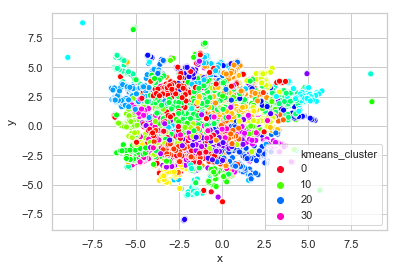

In [245]:
sns.scatterplot(data=df_embedding_tweets, 
                x='x', y='y', 
                hue='kmeans_cluster', palette=cmap_gistrain)

In [118]:
tweets.head()

,created_at,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,retweeted,text,truncated,user.id,user.screen_name,tknzd,is_retweet,is_reply,creation_hour,handles,connections
id,,,,,,,,,,,,,,,,
1125473150207188992,2019-05-06 14:51:23+00:00,0,NaN,NaN,0,False,CKM’s @Taneya giving talk at 2pm in Columbus R...,False,748973663517609985,VUMCKnowMgt,"[ckm, ’, s, @taneya, giving, talk, at, 2pm, in...",False,False,14,[@taneya],"[(@VUMCKnowMgt, @taneya)]"
1125472447321575424,2019-05-06 14:48:36+00:00,0,NaN,NaN,3,False,RT @LibrarianLizy: This grumbling and complain...,False,41206643,mandosally,"[rt, @librarianlizy, :, this, grumbling, and, ...",True,False,14,[@librarianlizy],"[(@mandosally, @librarianlizy)]"
1125472291926761473,2019-05-06 14:47:59+00:00,0,NaN,NaN,0,False,"Bring your questions, comments and suggestions...",True,3331772009,ItsKelsaB,"[bring, your, questions, ,, comments, and, sug...",False,False,14,[@medlibassn],"[(@ItsKelsaB, @medlibassn)]"
1125471492895121413,2019-05-06 14:44:48+00:00,0,NaN,NaN,0,False,Come to the diversity roundtable tonight and l...,False,287273757,jjpionke,"[come, to, the, diversity, roundtable, tonight...",False,False,14,[],[]
1125471199532933121,2019-05-06 14:43:38+00:00,2,NaN,NaN,0,False,Interested in creating a disability sig/caucus...,True,287273757,jjpionke,"[interested, in, creating, a, disability, sig,...",False,False,14,[],[]


In [120]:
tweets.shape

(3587, 16)

## Similarity of authors based on tweet content
A way to look at similarity of two tweeters, is to calculate the mean similarity of all their tweets to one another. Code below could be modified to allow a targeted calculation of any two authors:

```
#to create a new vector
vector = model.infer_vector(process("Merger news with verizon"))

# to find the siilarity with vector
model.similar_by_vector(vector)

# to find the most similar word to words in 2 document
model.wv.most_similar(documents[1][0])

#find similar documents to document 1
model.docvecs.most_similar(1)
```

# Appendix 2: Finding all book recommendations

In [588]:
df_bookrecs = tweets[(tweets.text.str.contains("bookrec", case=False)) |
                       (tweets.text.str.contains("book rec", case=False))
                      ]

In [589]:
df_bookrecs.shape

(57, 14)

In [595]:
def find_url(x):
    srch = re.search("(http[\S]+)", x)
    if srch:
        return srch.group(1)
    else:
        return None

In [596]:

df_bookrecs_cleaned = pd.DataFrame(df_bookrecs.text.apply(lambda x: re.sub("RT |@\w+:?", "", x).strip()
                                                  ).unique(
                                                  )
                                    ).sort_values(0)
df_bookrecs_cleaned['url'] = df_bookrecs_cleaned[0].apply(find_url)
df_bookrecs_cleaned.to_csv("mlanet19_bookrecs.csv")
df_bookrecs_cleaned

,0,url
18,"""There can never be too many resources for AID...",https://t.co/pvVkBbSoAd
28,#BookRec or #bookrecs and #MLAnet19,None
17,#bookrec #mlanet19 Dove sta amore\nWhere lies ...,https://t.co/53W9Efck9d
5,#bookrec for #microaggression panel #MLAnet19 ...,https://t.co/KmgTMkcmdd
14,"(1981) Audre Lorde, “The Uses of Anger: Women ...",https://t.co/xfWBxh2Hw4
16,Aids information sourcebook by bob malnowsky a...,https://t.co/Urbb2yuMFD
12,As Jerry Perry talks about the HIV/AIDS epidem...,None
19,As Jerry Perry talks about the HIV/AIDS epidem...,https://t.co/xQlfEhDKC1
32,Asking any #medlibs at #mlanet19 to use #bookr...,None
9,Audre Lorde “Your Silence will not protect you...,None
